# Robustness to readout-error

In [1]:
## import necessary packages
import sys
import numpy as np
import math
from cmath import cos, sin, exp, pi, sqrt
import random

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
# Set the default color cycle
# mpl.rcParams['axes.prop_cycle'] = 
# https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
colors = mpl.cycler(color=["c", "m", "r", "g", "b"]) 
# colors = mpl.cycler(color=["c", "m", "y", "r", "g", "b"]) 
mpl.rc('axes', grid=False, edgecolor='k', prop_cycle=colors)

# import matplotlib.pyplot as plt
# plt.rc('font', size=12)          # controls default text sizes, default 10
# plt.rcParams['legend.edgecolor'] = "m"
# plt.rcParams['figure.dpi'] = 400
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from qutip import *

from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# import quantum_state_utils
from quantum_state_utils import *


### 4-qubit case

In [38]:
n_qubit = 4
size_train = 5000
size_test = 1000
theta_limit = 0.5
phi_limit = 0.6
white_noise_limit = 1/2

##################### prepare dataset #######################

bi_sep_state = generate_noisy_biseparable(n_A=1,n_B=n_qubit-1, m=size_train) + generate_noisy_biseparable(n_A=2,n_B=n_qubit-2, m=size_train)
random.shuffle(bi_sep_state)
ghz4_state = generate_coherent_noisy_ghz_ensemble(n=n_qubit, m=size_train*2, theta_limit=theta_limit, phi_limit=phi_limit,p_limit=0.1)
# ghz3_state      = generate_noisy_ghz_ensemble(n=3,m=size_train*2,noise_limit=noise_limit)
w4_state        = generate_noisy_w_ensemble(n=n_qubit,m=size_train*2,noise_limit=white_noise_limit)

# label the states: biseparable with y=1, entangled with y=0
bi_sep_data = [bi_sep_state[:size_train], const_label(1,size_train)]
ghz4_data = [ghz4_state[:size_train], const_label(0,size_train)]
w4_data = [w4_state[:size_train], const_label(0,size_train)]

# 2-local Pauli observables of 4-qubit states
# pauli_tomo_operators = pauli_tensor_observables(n_qubit=n_qubit)
# pauli_tomo_labels = pauli_tensor_labels(n_qubit=n_qubit)
tomo_pauli_strings = pauli_tensor_labels(n_qubit=4)
pauli_dict = {'I': identity(2), 'X': sigmax(), 'Y': sigmay(), 'Z': sigmaz()}
len(tomo_pauli_strings)
two_local_pauli_strings = []
for pauli_operator in tomo_pauli_strings:
    if [*pauli_operator].count('I') == 2:
        two_local_pauli_strings.append(pauli_operator)
print(two_local_pauli_strings)
two_local_pauli_strings = np.array(two_local_pauli_strings)
two_local_pauli_operators = [tensor([pauli_dict[p] for p in list(string)]) for string in two_local_pauli_strings]
# print(two_local_pauli_operators[9])
# print(two_local_pauli_operators)
X, y = construct_training_dataset(
    states_labels=[bi_sep_data, ghz4_data, w4_data],
    operators=two_local_pauli_operators)
# print(X)

readout_noise_list = np.linspace(0.02, 0.11, 10)
##################### training ########################
to_features = 10
least_features = 2
# print(f'# randomly selected features: {to_features}')

# SVM
accuracy = 0.0
select_indices = random.sample([i for i in range(len(two_local_pauli_operators))], len(two_local_pauli_operators))
# print(select_indices)
epoch_num = 10
robust_list = []
for readout_sigma in readout_noise_list:
    epoch_count = 0
    feature_num_list = []
    readout_noise = np.random.normal(0, readout_sigma, X.shape)
    X = X + readout_noise
    print(f'===========readout_sigma: {readout_sigma}=============')
    # while accuracy < 0.999 or len(select_indices) > least_features or epoch_count < epoch_num:
    while epoch_count < epoch_num:
        # print(accuracy)
        for i in range(len(select_indices)):
            # drop the i-th feature
            temp_select_indices = select_indices[:i] + select_indices[i+1 :]
            # print(temp_select_indices)
            witness, accuracy = svm_train_witness(X=X[:, temp_select_indices], y=y, size_test=size_test)
            if accuracy > 0.999:
                select_indices = temp_select_indices
                # print(select_indices)
                select_labels = two_local_pauli_strings[select_indices]
                print('selected Pauli operators:', select_labels)
                break
            else:
                if  i==len(select_indices)-1:
                    epoch_count += 1
                    feature_num_list.append(len(select_indices))
                    print(f"didn't find better, restart: epoch={epoch_count}")
                    select_indices = random.sample(
                        [i for i in range(len(two_local_pauli_operators))],
                        len(two_local_pauli_operators))
    print('feature_num_list: ', feature_num_list)
    robust_list.append(feature_num_list)

print(feature_num_list)

generate_coherent_noisy_ghz_ensemble: n = 4, m = 10000, theta_limit = 0.50*pi, phi_limit = 0.60*pi, p_limit = 0.10
['IIXX', 'IIXY', 'IIXZ', 'IIYX', 'IIYY', 'IIYZ', 'IIZX', 'IIZY', 'IIZZ', 'IXIX', 'IXIY', 'IXIZ', 'IXXI', 'IXYI', 'IXZI', 'IYIX', 'IYIY', 'IYIZ', 'IYXI', 'IYYI', 'IYZI', 'IZIX', 'IZIY', 'IZIZ', 'IZXI', 'IZYI', 'IZZI', 'XIIX', 'XIIY', 'XIIZ', 'XIXI', 'XIYI', 'XIZI', 'XXII', 'XYII', 'XZII', 'YIIX', 'YIIY', 'YIIZ', 'YIXI', 'YIYI', 'YIZI', 'YXII', 'YYII', 'YZII', 'ZIIX', 'ZIIY', 'ZIIZ', 'ZIXI', 'ZIYI', 'ZIZI', 'ZXII', 'ZYII', 'ZZII']
===========readout_sigma: 0.02=============
train score: 1.0000; test score: 1.0000; number of features: 53
selected Pauli operators: ['IXXI' 'IZZI' 'IIYX' 'IXYI' 'ZIIZ' 'XIXI' 'YIIZ' 'IIZX' 'IIXY' 'IYIY'
 'IYIZ' 'IXIY' 'IIXX' 'IYYI' 'XYII' 'YXII' 'ZIIX' 'YZII' 'YIIX' 'XIIY'
 'IIYY' 'IIXZ' 'YIZI' 'ZIZI' 'IYXI' 'IYZI' 'IZXI' 'IXIZ' 'XIIX' 'IIZZ'
 'IIYZ' 'ZIYI' 'YIYI' 'ZIIY' 'IZIZ' 'IXZI' 'YIXI' 'XIYI' 'XIZI' 'ZXII'
 'ZZII' 'YIIY' 'IIZY' 'XXII' 'IZIY

error_list: [[3, 2, 3, 3, 3, 3, 3, 2, 3, 3], [3, 3, 3, 3, 3, 5, 10, 3, 3, 4], [5, 5, 4, 3, 9, 3, 9, 6, 4, 5], [12, 9, 5, 6, 10, 6, 8, 12, 14, 12], [17, 8, 7, 9, 17, 22, 19, 6, 13, 14], [17, 19, 15, 18, 18, 15, 16, 17, 24, 23], [26, 28, 22, 27, 17, 29, 30, 20, 17, 22], [30, 25, 20, 35, 28, 29, 26, 18, 36, 31], [54, 54, 54, 54, 54, 54, 54, 54, 54, 54], [54, 54, 54, 54, 54, 54, 54, 54, 54, 54]]
[0.02       0.03111111 0.04222222 0.05333333 0.06444444 0.07555556
 0.08666667 0.09777778 0.10888889 0.12      ]


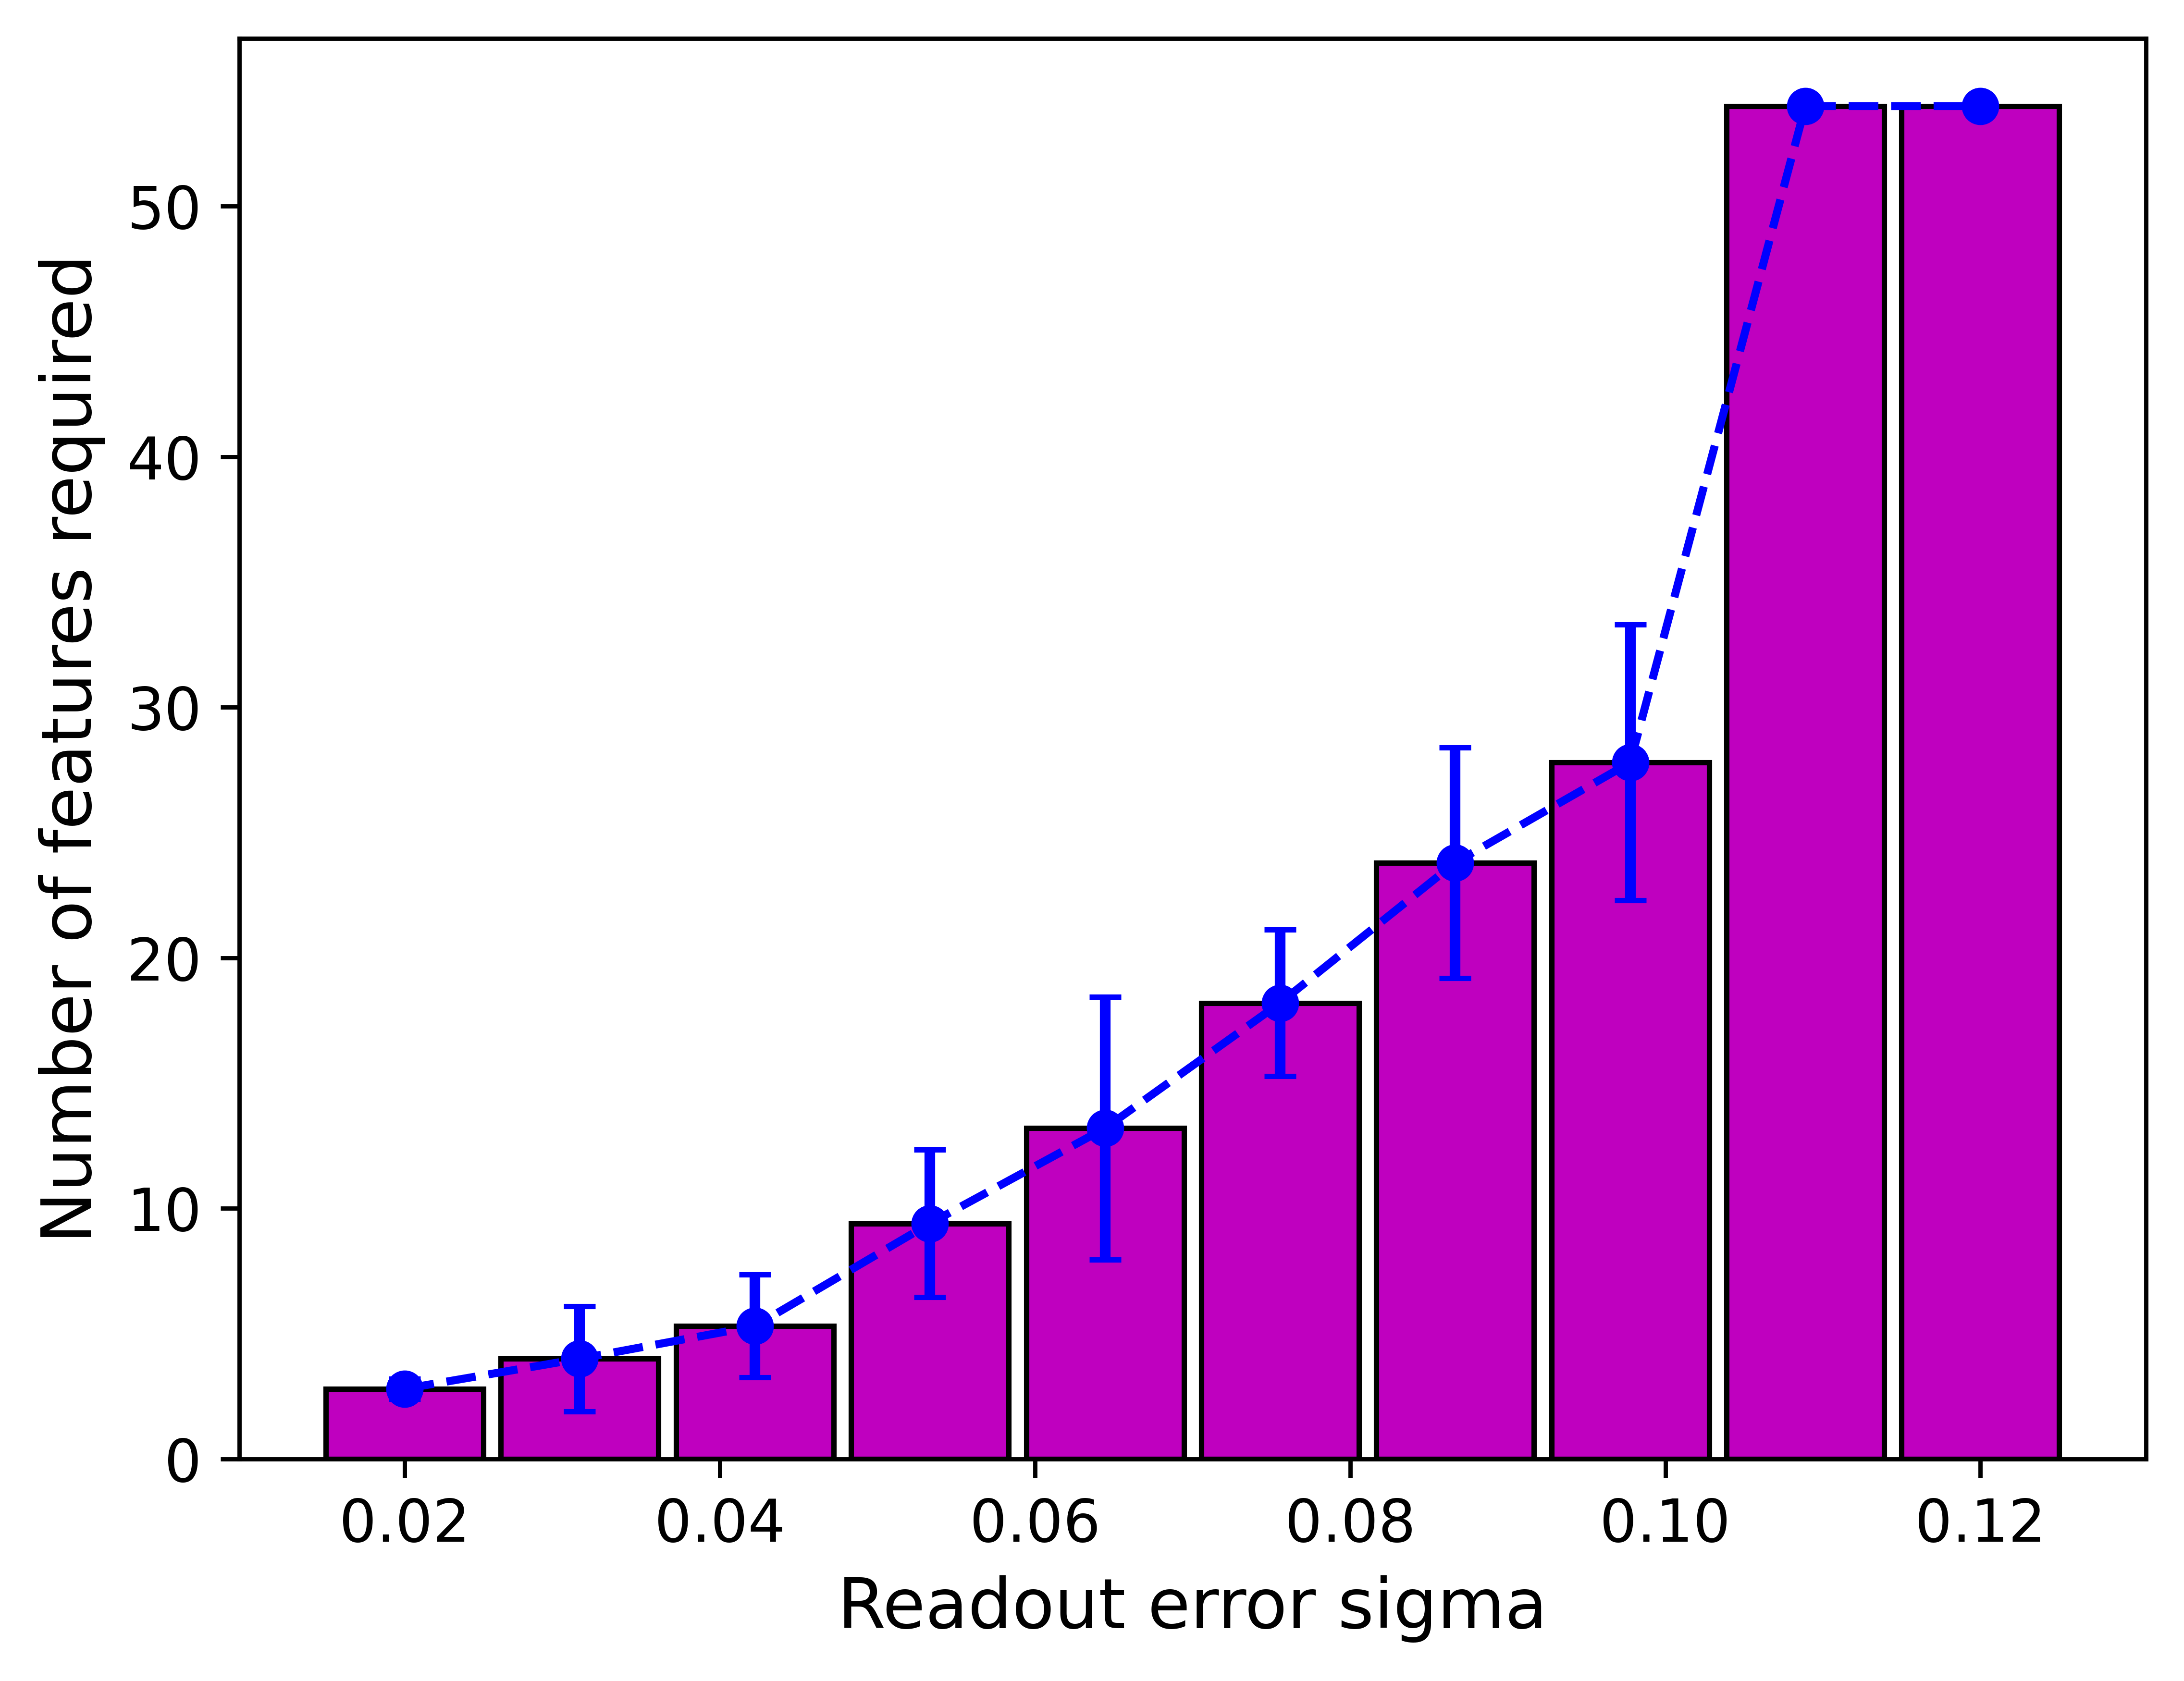

In [39]:
print('error_list:', robust_list)
y = []
e = []
for i in range(len(robust_list)):
    y.append(np.mean(robust_list[i]))
    # e.append(np.var(robust_list[i]))
    e.append(np.std(robust_list[i]))

print(readout_noise_list)
plt.bar(readout_noise_list, y, width=0.01, align="center", color='m', edgecolor = "black")
plt.errorbar(readout_noise_list, y, yerr=e, linestyle="dashed", fmt="o", color="blue", capsize=3, elinewidth=2)
plt.xlabel('Readout error sigma')
plt.ylabel('Number of features required')
# plt.legend(['Independent estimation','Randomized shadow','Derandomized shadow'])
plt.savefig(f'robust_sigma_n={epoch_num}.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:

##################### testing ########################
bi_sep_test = bi_sep_state[size_train:]
ghz4_test = ghz4_state[size_train:]
w4_test = w4_state[size_train:]

test_dataset = [bi_sep_test, ghz4_test, w4_test]

feature_test_set = [
    evaluate_features(operators=two_local_pauli_operators,
                      states=data)[:, select_indices] for data in test_dataset
]
test_expectation_lists = evaluate_witness(witness=witness, features_set=feature_test_set)

fig, ax = plt.subplots(figsize=(6, 4))
title = f'ML witness (noise = {white_noise_limit:.2f} )'
comparison_legend = ['4-qubit bi-separable', 'GHZ with coherent noise', 'W with white noise']

plot_expectation_hist(ax, test_expectation_lists, comparison_legend, title='', xlabel=r'$f(x_{\rho,\tilde{\sigma}})$', legend_loc='upper center')

##################### plot ########################

# fig.show()
plt.savefig('three_qubit_hist_ML_4qubit_readout_noise.png', dpi=400, bbox_inches='tight')

['ZIYY' 'IXII' 'IZZI' 'YZYY' 'ZIZZ']
['IIZZ' 'IIXI' 'YYZZ' 'YIII' 'IYZX']
['ZZII' 'IXIX' 'IYYI' 'IYIY']
['IIZZ' 'XIIZ' 'IZYI' 'YIYI']
['ZIIZ' 'IZIX' 'XIIX' 'IYYI']